# **Libreries**

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.9 MB/s eta 0:00:00


In [4]:
!pip install datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.7 MB/s eta 0:00:00


In [5]:
from datasets import load_dataset,Dataset
from huggingface_hub import notebook_login
from transformers import (
      DefaultDataCollator,
      AutoModelForQuestionAnswering,
      TrainingArguments,
      Trainer,
      AutoTokenizer,
      pipeline
        )


# **Data**

### **1.Loading the data**

In [6]:
ara_squad = load_dataset("Mostafa3zazi/Arabic_SQuAD",split='train[:5000]')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/48344 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Mostafa3zazi___parquet/Mostafa3zazi--Arabic_SQuAD-e736ef21eeb50256/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


### **2.basic data preparation**

In [7]:
#add end off answers column in the dataset
def prepare(example):
  example['answer_end'] = example['answer_start']+len(example['text'])
  return example

In [8]:
ara_squad = ara_squad.map(prepare)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

### **3.removing unecessary columns**

In [9]:
ara_squad = ara_squad.remove_columns(['index','c_id'])

### **4.spliting the data**

In [10]:
ara_squad = ara_squad.train_test_split(test_size=0.2)

In [11]:
ara_squad

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'text', 'answer_start', 'answer_end'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['question', 'context', 'text', 'answer_start', 'answer_end'],
        num_rows: 1000
    })
})

In [12]:
ara_squad['train'][100]

{'question': 'ما الرقم القياسي العالمي الذي يحتفظ به الرياضي الإريتري Zersenay Tadese؟',
 'context': 'تعتبر كرة القدم وركوب الدراجات أكثر الرياضات شعبية في إريتريا . في السنوات الأخيرة ، شهد الرياضيون الإريتريون أيض ا نجاح ا متزايد ا على الساحة الدولية . Zersenay تاديسي ، رياضي إريتري ، حالي ا يحمل الرقم القياسي العالمي في نصف مسافة سباق الماراثون . ت عقد جولة إريتريا ، وهي حدث دولي متعدد المراحل لركوب الدراجات ، سنوي ا في جميع أنحاء البلاد . حقق الفريق الوطني لركوب الدراجات في إريتريا الكثير من النجاح ، حيث فاز ببطولة القارية لسباق الدراجات لعدة سنوات متتالية . تم توقيع ستة متسابقين إريتريين على فرق الدراجات الدولية ، بما في ذلك ناتنايل برهان ودانييل تكليحيمانوت . حصل برهان على لقب أفضل رياضي أفريقي في العام 2013 ، متقدما على لاعبي كرة القدم ييا توري وديدييه دروغبا ، بينما أصبح تيخليمانوت أول إريتري يركب سباق فولتا أسبانيا في عام 2012 . في عام 2015 فاز تكلاهايمانوت بتصنيف ملك الجبال في كريتريوم دو دوفين . أصبح تيكليهمانوت وزميله الإريتري مرهاوي كودوس أول متسابقين أفارقة أسود يتنافسون 

# **Authentication to hugging face using personal token**

In [ ]:
notebook_login()

# **Preprocessing the data for question answering**

In [13]:
tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [14]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    #initilizing the tokenizer variable
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["text"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer_start = examples["answer_start"][i]
        answer_end = examples["answer_end"][i]
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > answer_end or offset[context_end][1] < answer_start:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise, it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= answer_start:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= answer_end:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs


applying the preprocess_function to one example

In [15]:
input = tokenizer(
        ara_squad['train'][100]['question'],
        ara_squad['train'][100]['context'],
        max_length=150, # 150 as an example
        truncation="only_second",
        padding="max_length",
)

In [16]:
print(len(input['token_type_ids']))

150


In [17]:
print(len(input['attention_mask']))

150


In [18]:
len(input["input_ids"])

150

In [22]:
tokenizer.decode(input['input_ids'])

'[CLS] ما الرقم القياسي العالمي الذي يحتفظ به الرياضي الاريتري zersenay tadese ؟ [SEP] تعتبر كرة القدم وركوب الدراجات اكثر الرياضات شعبية في اريتريا. في السنوات الاخيرة ، شهد الرياضيون الاريتريون ايض ا نجاح ا متزايد ا على الساحة الدولية. zersenay تاديسي ، رياضي اريتري ، حالي ا يحمل الرقم القياسي العالمي في نصف مسافة سباق الماراثون. ت عقد جولة اريتريا ، وهي حدث دولي متعدد المراحل لركوب الدراجات ، سنوي ا في جميع انحاء البلاد. حقق الفريق الوطني لركوب الدراجات في اريتريا الكثير من النجاح ، حيث فاز ببطولة القارية لسباق الدراجات لعدة سنوات متتالية. تم توقيع ستة متسابقين اريتريين على فرق الدراجات الدولية ، [SEP]'

to all the examples

In [ ]:
tokenized_data = ara_squad.map(preprocess_function, batched=True, remove_columns=ara_squad["train"].column_names)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 1000
    })
})

# **Fine tuning**

In [ ]:
data_collator = DefaultDataCollator()

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained("SI2M-Lab/DarijaBERT")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized

In [ ]:
training_args = TrainingArguments(
    output_dir="my_qa_model",
    evaluation_strategy="epoch",
    learning_rate=2e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs',
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.log_metrics = True


/content/my_qa_model is already a clone of https://huggingface.co/JasperV13/my_qa_model. Make sure you pull the latest changes with `repo.git_pull()`.


In [23]:
#can't do the training again beacause we need a gpu
#trainer.train()

To add the model to the hub link :
[my_qa_model](https://https://huggingface.co/JasperV13/my_qa_model)



In [ ]:
trainer.push_to_hub()

To https://huggingface.co/JasperV13/my_qa_model
   cebd661..99285f7  main -> main

   cebd661..99285f7  main -> main

To https://huggingface.co/JasperV13/my_qa_model
   99285f7..a2128b7  main -> main

   99285f7..a2128b7  main -> main



'https://huggingface.co/JasperV13/my_qa_model/commit/99285f73e6ace7f98f5fdd8be9e8cd561e7629bb'

# **evaluation**

humain feedback

In [ ]:
question = "باش مشهور الناصر صلاح الدين يوسف بن أيوب"
context = """الناصر صلاح الدين يوسف بن أيوب لي مشهور بين أوساط لمسلمين و المؤرخين ب "صلاح الدين الأيوبي"، هو حاكم ؤ قائد عسكري مسلم أصولو كردية، كيتعتابر هو لمؤسيس لفعلي ديال الدولة لأيوبية لي وحدات أجزاء مهمة ف لجزيرة لعربية ؤ شرق لأوسط بالضبط تحت راية لعباسيين لي قضات على الدولة لفاطمية بعد 262 سنة. ولعب صلاح دور كبير فالتاريخ لإسلامي حيت رجّع بزاف ديال لأراضي لمهمة بحال فلسطين ؤ لبنان، لي كانو تحت سيطرة صليبيين د ؤروپا، وتشهر بزاف فاش رجع لقدس ف معركة حطين لمشهورة"""

In [ ]:
question_answerer = pipeline("question-answering", model="JasperV13/my_qa_model")
question_answerer(question=question, context=context)

{'score': 0.0933503583073616,
 'start': 69,
 'end': 91,
 'answer': 'ب "صلاح الدين الأيوبي"'}

with metrics : EM and F1 score

In [ ]:
eval_data = load_dataset("Mostafa3zazi/Arabic_SQuAD",split='train[:1000]')

In [ ]:
eval_data

Dataset({
    features: ['index', 'question', 'context', 'text', 'answer_start', 'c_id', 'answer_end'],
    num_rows: 1000
})

In [ ]:

# Initialize the new dataset with the desired structure
new_eval_data = {
    'id': [],
    'title': [],
    'context': [],
    'question': [],
    'answers': []
}

# Iterate over the rows of the original dataset
for row in eval_data:
    # Extract the necessary information from the row
    index = row['index']
    question = row['question']
    context = row['context']
    text = row['text']
    answer_start = row['answer_start']

    # Add the new entry to the new dataset
    new_eval_data['id'].append(index)
    new_eval_data['title'].append('')
    new_eval_data['context'].append(context)
    new_eval_data['question'].append(question)
    new_eval_data['answers'].append({
        'text': [text],
        'answer_start': [answer_start]
    })

# Create the new dataset
new_dataset = Dataset.from_dict(new_eval_data)

# Print the new dataset
print(new_dataset)


Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 1000
})


In [ ]:
new_dataset[0]

{'id': '570bce516b8089140040fa42',
 'title': '',
 'context': 'يعتمد ASCII أساس ا على الأبجدية الإنجليزية ، ويقوم بترميز 128 حرف ا محدد ا في أعداد صحيحة من سبعة أجزاء كما هو موضح في مخطط ASCII على اليمين . الأحرف المشفرة هي الأرقام من 0 إلى 9 ، والأحرف الصغيرة ا إلى ز ، والأحرف الكبيرة A إلى Z ، ورموز الترقيم الأساسية ، ورموز التحكم التي نشأت مع أجهزة تيليتيبي ، ومساحة . على سبيل المثال ، سيصبح الحرف الصغير ج 1101010 والعشري 106 . تتضمن ASCII تعريفات لـ 128 حرف ا 33 حرف ا تحكم ا غير الطباعة العديد منها الآن قديمة تؤثر على كيفية معالجة النص والمساحة و 95 حرف ا قابلا للطباعة ، بما في ذلك المساحة التي ي عتبر رسم ا غير مرئي 223 .',
 'question': 'ما هو ASCII على أساس؟',
 'answers': {'answer_end': [42],
  'answer_start': [23],
  'text': ['الأبجدية الإنجليزية']}}

In [ ]:
from evaluate import evaluator

task_evaluator = evaluator("question-answering")

eval_results = task_evaluator.compute(
    model_or_pipeline="JasperV13/my_qa_model",
    data=new_dataset,
    strategy="bootstrap",
    n_resamples=30
)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
eval_results

{'exact_match': {'confidence_interval': (58.076382091233064,
   63.66838097802128),
  'standard_error': 1.6388564838669193,
  'score': 60.5},
 'f1': {'confidence_interval': (62.83209446904143, 67.8213205446824),
  'standard_error': 1.3840583855294575,
  'score': 65.09796513954032},
 'total_time_in_seconds': 518.3064318080001,
 'samples_per_second': 1.9293605840693813,
 'latency_in_seconds': 0.5183064318080001}

In [ ]:
import matplotlib.pyplot as plt

# Performance metrics
exact_match = {
    'confidence_interval': (58.08, 63.67),
    'standard_error': 1.64,
    'score': 60.5
}

f1_score = {
    'confidence_interval': (62.83, 67.82),
    'standard_error': 1.38,
    'score': 65.1
}

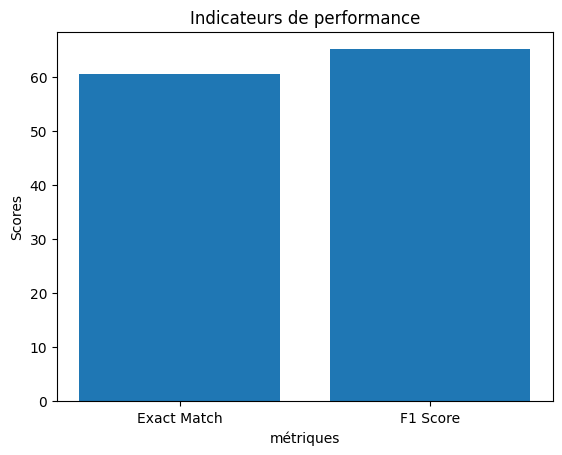

In [ ]:
# Bar chart
metrics = ['Exact Match', 'F1 Score']
scores = [exact_match['score'], f1_score['score']]

plt.bar(metrics, scores)
plt.xlabel('métriques')
plt.ylabel('Scores')
plt.title('Indicateurs de performance')
plt.show()